# Algo Pairs-Trading Strategy with Least Square and Kalman Filtering

## Introduction

Given the day-end close prices of two financial assets $S_{1,t}$ and $S_{2,t}$, this python program will:

1. Perform simple data exploration
2. Check if there is any cointegration relationship between $Log S_{1,t}$ and $Log S_{2,t}$ 
3. Estimate the (time-dependent) parameters ($γ_{(t)}$ for slope and $μ_{(t)}$ for mean spread) of this relationship using Least Square and Kalman Filtering 
4. Trade on this relationship and access the PLs


## Setting and data prepration

### Import Standard Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import datetime
import numpy as np

### Basic Settings to control workflows

In [2]:
#for currency conversion
ccy_conv = 0

#to set warning on/off
warning_off = 1

#join stock 1 & 2
# 1 = align by outer join (not implemented for now)
# 2 = aligh by inner join
join_option = 2

#data source
# 0 = yahoo div unadjusted
# 1 = yahoo div adjusted
# 2 = quandl
# 3 = csv (not implemented)
data_source = 1

#data export to csv
data_export = 1

# training vs testing split option
# 1 = split by fraction
# 2 = split by training data length
# 3 = split by date
split_option = 1


if warning_off == 1:
    import warnings
    warnings.filterwarnings("ignore")

### Period and Asset Settings

In [3]:
start = "2000-08-01"
end = '2003-12-31'

stockcode1 = 'EWH'
stockcode2 = 'EWZ'

### Training data setting

In [4]:
# fraction of data for training (for split_option = 1)
train_fraction = 0.3 

# training data length (for split_option = 2)
train_len = 100

# split_date of data for training (for split_option = 3)
split_date = np.datetime64('2001-01-01')

### Trading Threshold setting

In [5]:
long_threshold = -0.7
short_threshold = 0.7

### Financial Data download

In [6]:
# for yahoo finance

if data_source ==0:
    import yfinance as yf
    s1 = yf.download(stockcode1,start,end)
    s2 = yf.download(stockcode2,start,end)

elif data_source ==1: 
    import yfinance as yf
    s1ticker = yf.Ticker(stockcode1)
    s2ticker = yf.Ticker(stockcode2)
    s1 = s1ticker.history(start=start,  end=end)
    s2 = s2ticker.history(start=start,  end=end)
    
# for quandl

elif data_source ==2:

    import quandl

    QUANDL_API_KEY = '7mhoK7W3HAwQmxfo4Qts'  # Your own Quandl key here
    quandl.ApiConfig.api_key = QUANDL_API_KEY

    s1 = quandl.get(stockcode1,start_date=start,end_date=end)
    
    # take the previous close price as proxy for Open 
    s1.rename(columns={'Nominal Price': 'Close', 'Previous Close': 'Open'}, inplace=True)
    s2 = quandl.get(stockcode2,start_date=start,end_date=end)
    s2.rename(columns={'Nominal Price': 'Close', 'Previous Close': 'Open'}, inplace=True)

### Download FX Rates and convert prices to USD if needed

In [7]:
if ccy_conv ==1: 
    if s1ticker.info['currency'] != 'USD':
        c1ticker = yf.Ticker(s1ticker.info['currency'] + '=X')
        c1 = c1ticker.history(start=start,  end=end)


if ccy_conv ==1:
    if s2ticker.info['currency'] != 'USD':
        c2ticker = yf.Ticker(s2ticker.info['currency'] + '=X')
        c2 = c2ticker.history(start=start,  end=end)
        
if ccy_conv ==1:
    if s1ticker.info['currency'] != 'USD':
        s1, c1 = s1.align(c1, join='inner', axis=0)
        s1['Open'] = s1['Open'] / c1['Close']
        s1['High'] = s1['High'] / c1['Close']
        s1['Low'] = s1['Low'] / c1['Close']
        s1['Close'] = s1['Close'] / c1['Close']

if ccy_conv ==1:
    if s2ticker.info['currency'] != 'USD':    
        s2, c2 = s2.align(c2, join='inner', axis=0)
        s2['Open'] = s2['Open'] / c2['Close']
        s2['High'] = s2['High'] / c2['Close']
        s2['Low'] = s2['Low'] / c2['Close']
        s2['Close'] = s2['Close'] / c2['Close']

### Align $Y_{1,t}$ and $Y_{2,t}$

In [8]:
if join_option == 1:
    s1, s2 = s1.align(s2, join='outer', axis=0)

if join_option == 2:
    s1, s2 = s1.align(s2, join='inner', axis=0)

### Compute Normalized Close, Log Return and Log Price

In [9]:
# Normalized Close
first = s1.head(1)['Close'].values
s1['Normalized_Close'] = s1['Close'] / first

first = s2.head(1)['Close'].values
s2['Normalized_Close'] = s2['Close'] / first

# Log Close
s1['Log_Close'] = np.log(s1['Close'])
s2['Log_Close'] = np.log(s2['Close'])

# Log Returns
s1['Returns'] = np.log(s1['Close']/s1['Close'].shift(1))
s2['Returns'] = np.log(s2['Close']/s2['Close'].shift(1))

# drop NA (first row)
s1.dropna(subset = ["Returns"], inplace=True)
s2.dropna(subset = ["Returns"], inplace=True)

### Compute Training vs Testing Split

In [10]:
if split_option == 1:
    train_len =  round(len(s1)*train_fraction)
    split_date = s1[(train_len):].head(1).index.values[0]
elif split_option == 2:
    train_fraction = train_len / len(s1)
    split_date = s1[(train_len):].head(1).index.values[0]
elif split_option == 3:
    train_len = s1.index.get_loc(split_date, method = 'backfill')
    train_fraction = train_len / len(s1)
    split_date = s1[(train_len):].head(1).index.values[0]

print('Total data length = ', len(s1))
print('Train Length = ', train_len)
print('Train Fraction = ', train_fraction)    
print('Testing dataset starts on', pd.to_datetime(str(split_date)).strftime('%Y.%m.%d'))

Total data length =  857
Train Length =  257
Train Fraction =  0.3
Testing dataset starts on 2001.08.08


## Data Exploration

### Close Plot

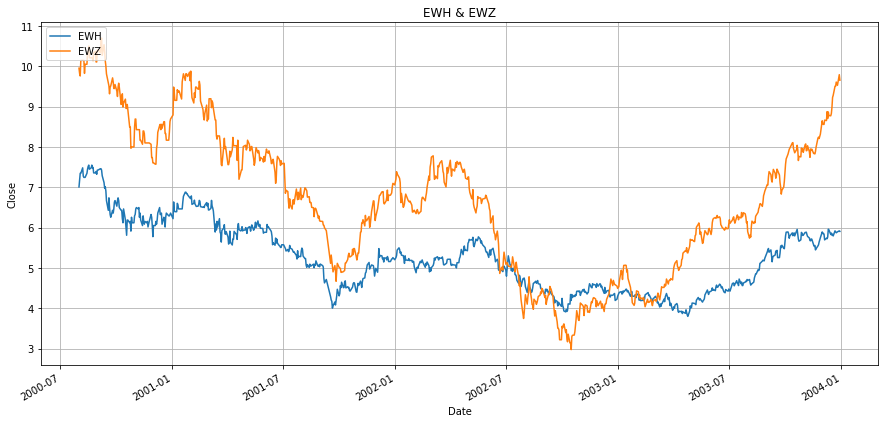

In [11]:
s1['Close'].plot(label = stockcode1, figsize = (15,7))
s2['Close'].plot(label = stockcode2)

plt.grid(True)
plt.legend(loc="upper left")
plt.ylabel(ylabel='Close')
plt.title('%s & %s' % (stockcode1, stockcode2));

### Normalized Close Plot

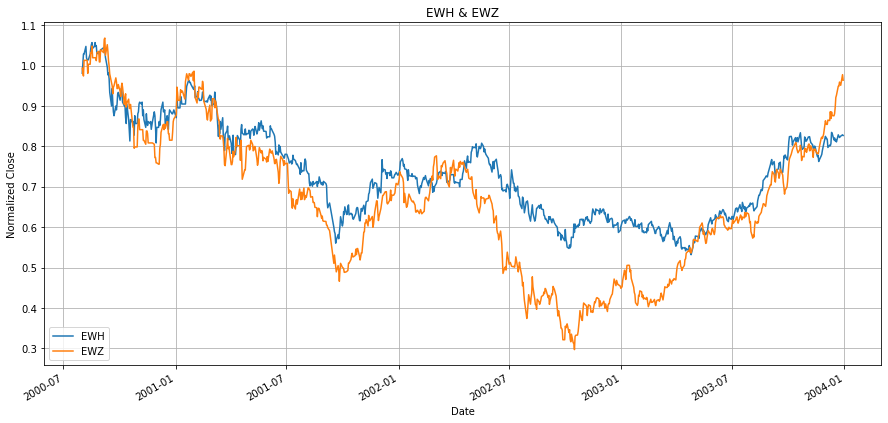

In [12]:
s1['Normalized_Close'].plot(label = stockcode1, figsize = (15,7))
s2['Normalized_Close'].plot(label = stockcode2)

plt.grid(True)
plt.legend(loc="lower left")
plt.ylabel(ylabel='Normalized Close')
plt.title('%s & %s' % (stockcode1, stockcode2));

### Log Close Plot

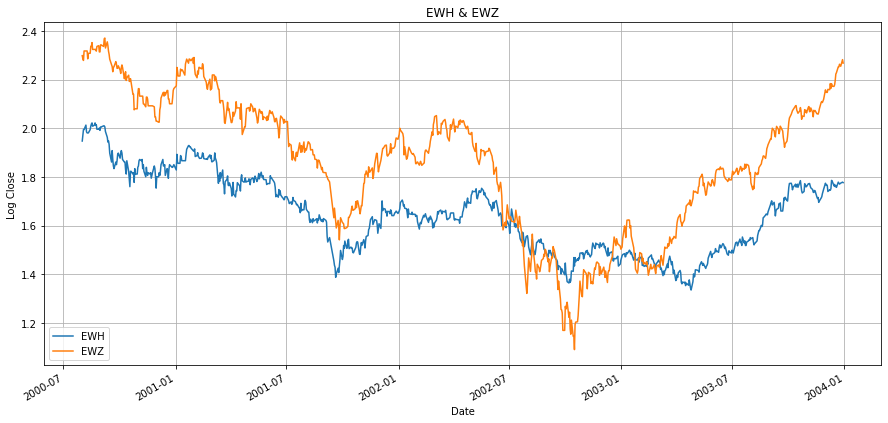

In [13]:
s1['Log_Close'].plot(label = stockcode1, figsize = (15,7))
s2['Log_Close'].plot(label = stockcode2)

plt.grid(True)
plt.legend(loc="lower left")
plt.ylabel(ylabel='Log Close')
plt.title('%s & %s' % (stockcode1, stockcode2));

### Returns Plot

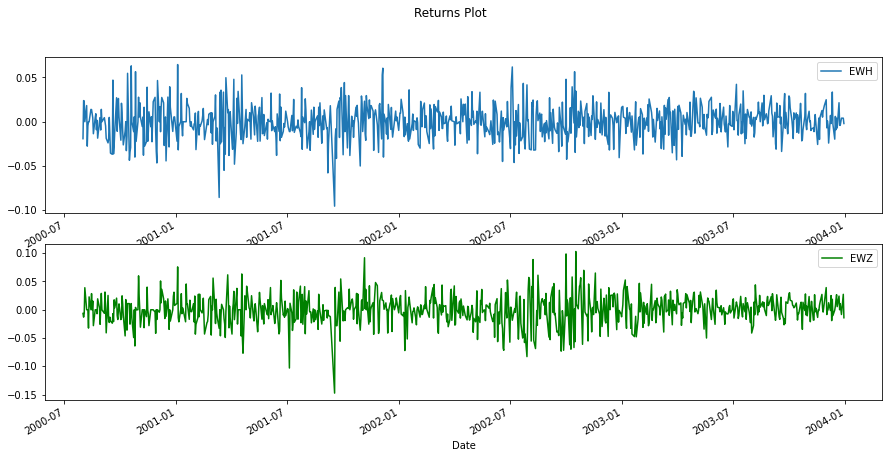

In [14]:
plt.subplot(2, 1, 1)
s1['Returns'].plot(label = stockcode1, figsize = (15,7))
plt.legend()

plt.subplot(2, 1, 2)
s2['Returns'].plot(label = stockcode2, color = 'green')
plt.legend()

plt.suptitle("Returns Plot");

### Returns Distribution Plot

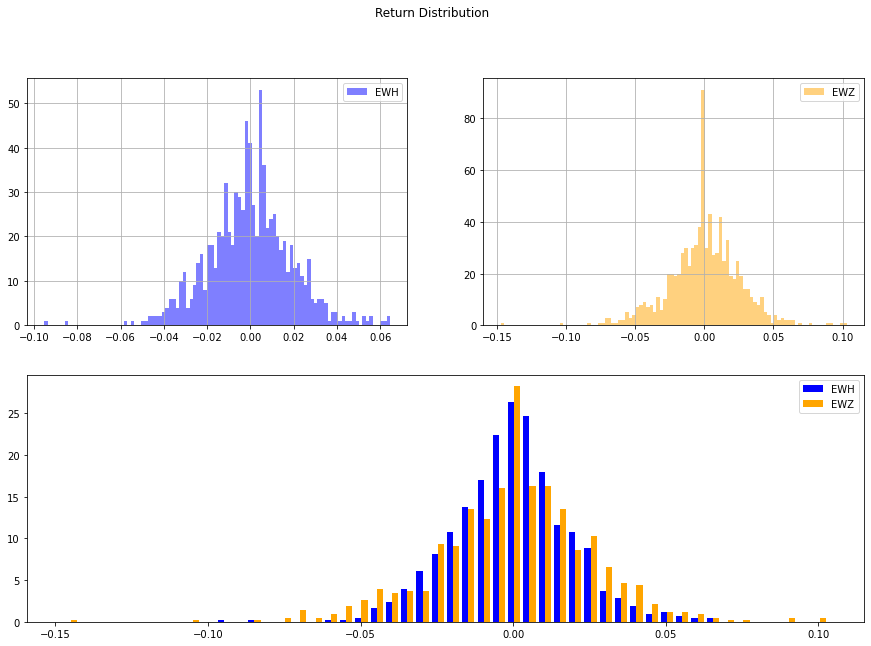

In [15]:
plt.subplot(2, 2, 1)
s1['Returns'].hist(bins = 100, label = stockcode1, alpha = 0.5, figsize = (15,10), color = 'blue')
plt.legend();

plt.subplot(2, 2, 2)
s2['Returns'].hist(bins = 100, label = stockcode2, alpha = 0.5, color = 'orange')
plt.legend();

plt.subplot(2, 1, 2)
colors = ['blue', 'orange']
label = [stockcode1, stockcode2]
plt.hist((s1['Returns'], s2['Returns']), 50, density = True, histtype ='bar', color = colors, label = label)

plt.legend();

plt.suptitle("Return Distribution");

### Return Covariance Plot

#### Covariance plot with training data only

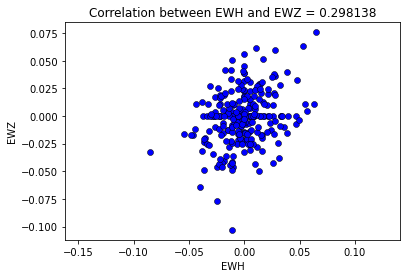

In [16]:
from numpy import cov
covariance = cov(s1[:train_len]['Returns'], s2[:train_len]['Returns'])
correlation = covariance[0, 1] / (np.sqrt(covariance[0, 0] * covariance[1, 1]) )


plt.plot(s1[:train_len]['Returns'],s2[:train_len]['Returns'], 'o', c='blue',
         markeredgewidth = 0.5,
         markeredgecolor = 'black')
plt.title('Correlation between %s and %s = %f' % (stockcode1, stockcode2, correlation))
plt.xlabel(stockcode1)
plt.ylabel(stockcode2)
plt.axis('equal')

plt.show() 

#### Covariance plot with full dataset

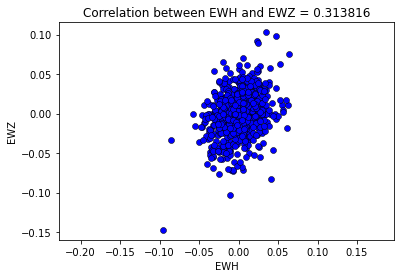

In [17]:
from numpy import cov
covariance = cov(s1['Returns'], s2['Returns'])
correlation = covariance[0, 1] / (np.sqrt(covariance[0, 0] * covariance[1, 1]) )

plt.plot(s1['Returns'],s2['Returns'], 'o', c='blue',
         markeredgewidth = 0.5,
         markeredgecolor = 'black')
plt.title('Correlation between %s and %s = %f' % (stockcode1, stockcode2, correlation))
plt.xlabel(stockcode1)
plt.ylabel(stockcode2)
plt.axis('equal')

plt.show() 

## Basic Spread Analysis

$$ \begin{align}
Simple Spread_t &=Normalized Close_{1t}− Normalized Close_{2t}\\
Squared Spread_t &= Simple Spread_t^2
\end{align}$$

In [18]:
s1s2 = s1.join(s2, lsuffix='1', rsuffix='2');
s1s2['Simple_Spread'] = s1s2['Normalized_Close1'] - s1s2['Normalized_Close2'];
s1s2['Squared_Spread'] = s1s2['Simple_Spread'] * s1s2['Simple_Spread']

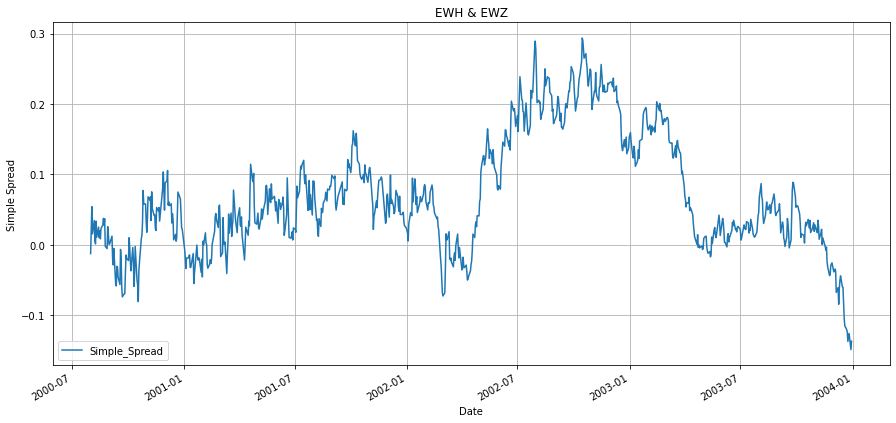

In [19]:
s1s2['Simple_Spread'].plot(figsize = (15,7))

plt.grid(True)
plt.legend(loc="lower left")
plt.ylabel(ylabel='Simple Spread')
plt.title('%s & %s' % (stockcode1, stockcode2));

Total sum of squared spread is 9.968660.
Average sum of squared spread is 0.011632.


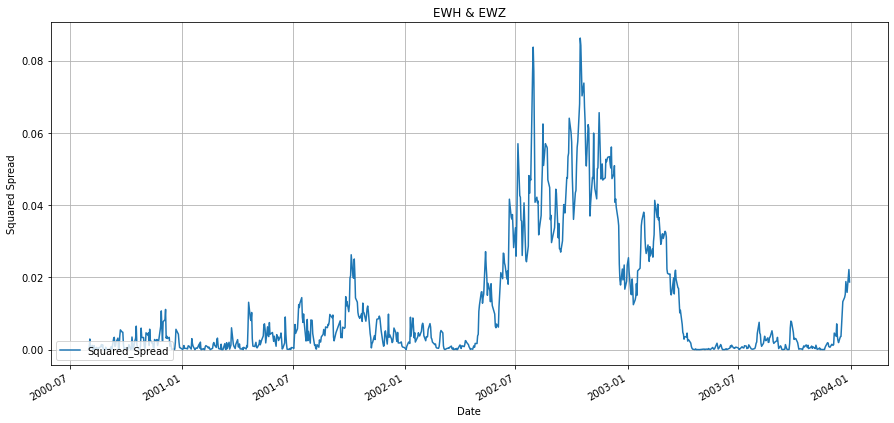

In [20]:
s1s2['Squared_Spread'].plot(figsize = (15,7))

print('Total sum of squared spread is %f.' % (s1s2['Squared_Spread'].sum()))
print('Average sum of squared spread is %f.' % (s1s2['Squared_Spread'].mean()))

plt.grid(True)
plt.legend(loc="lower left")
plt.ylabel(ylabel='Squared Spread')
plt.title('%s & %s' % (stockcode1, stockcode2));

## Log close analysis & Cointegration test

Use $s_{i,t}$ to represent the Log Close Price for $i = 1, 2$.

From now on our main focus will be on $s_{i,t}$ instead of $S_i$.

$$ \begin{align}
s_{i,t} &= log(Close_{i,t})\\
Log Return_{i,t} &= log(\frac{Close_{i,t}}{Close_{1i, t-1}})\\
&= log(Close_{i,t}) - log(Close_{i, t-1})\\
&= s_{i,t} - s_{i,t-1}
\end{align}$$

### Cointegration Test (Engle-Granger)

In [21]:
# Cointegration test for Log Close using training data only

import statsmodels.tsa.stattools as ts 

result, p, critical =ts.coint(s1s2['Log_Close1'][:train_len], s1s2['Log_Close2'][:train_len])

print('Cointegration test for Log Close (training dataset):')

print('Cointegration test t-stat = %f' % (result))

print('P-value = %f' % (p))

print('Critical Values for 1%% 5%% 10%% are %f & %f & %f.' % (critical[0], critical[1], critical[2]))

Cointegration test for Log Close (training dataset):
Cointegration test t-stat = -4.247770
P-value = 0.003084
Critical Values for 1% 5% 10% are -3.939732 & -3.360102 & -3.061059.


In [22]:
# Cointegration test for Log Close using full dataset

result, p, critical =ts.coint(s1s2['Log_Close1'], s1s2['Log_Close2'])

print('Cointegration test for Log Close (training dataset):')

print('Cointegration test t-stat = %f' % (result))

print('P-value = %f' % (p))

print('Critical Values for 1%% 5%% 10%% are %f & %f & %f.' % (critical[0], critical[1], critical[2]))

Cointegration test for Log Close (training dataset):
Cointegration test t-stat = -2.526309
P-value = 0.267591
Critical Values for 1% 5% 10% are -3.909280 & -3.343277 & -3.049408.


## Define Reuseable Functions

In [23]:
def compute_weights(df, Gamma_Col, W1_Col, W2_Col):
    df[W1_Col] = 1/(1+df[Gamma_Col])
    df[W2_Col] = -df[Gamma_Col]/(1+df[Gamma_Col])

In [24]:
def compute_spread(df, s1_Col, s2_Col, Mu_Col, Gamma_Col, Spread_Col):
    
    df[Spread_Col] = 0
    
    df['temp_W1'] = 1/(1+df[Gamma_Col])
    df['temp_W2'] = -df[Gamma_Col] / (1+df[Gamma_Col])
    
    df[Spread_Col] = df[s1_Col]*df['temp_W1'] + df[s2_Col] *df['temp_W2'] - df[Mu_Col] / (1+df[Gamma_Col])
    
    #delete the temp columns
    df.drop(columns=['temp_W1','temp_W2'], axis=1, inplace=True)

In [25]:
def compute_returns(df, Signal_Col, W1_Col, W2_Col, Daily_Returns_Col, Cum_Returns_Col):
    
    df[Daily_Returns_Col] = df[Signal_Col].shift(1) * (df[W1_Col].shift(1) * df['Returns1'] 
                                                       + df[W2_Col].shift(1) * df['Returns2'])
    df[Cum_Returns_Col] = (1+df[Daily_Returns_Col]).cumprod()

In [26]:
def generate_Z_score_simple(df, Spread_Col, Z_Score_Col, n=120):

    spread_std = df[:n][Spread_Col].std()
    df[Z_Score_Col] = (df[Spread_Col]) / spread_std

In [27]:
def generate_Z_score_EMA(df, Spread_Col, Mean_Col, Demeaned_Col, Demeaned_Squared_Col, Var_Col, Z_Score_Col, n=120):
    
    # compute the Exp Weighted Mean
    df[Mean_Col] = df[Spread_Col].ewm(span=n, min_periods=n).mean()
    df[[Mean_Col]] = df[[Mean_Col]].fillna(method="bfill")
    
    # Demean it 
    df[Demeaned_Col] = df[Spread_Col] - df[Mean_Col]
    
    df[Demeaned_Squared_Col] = df[Demeaned_Col]**2
    
    # Compute Variance
    df[Var_Col] = df[Demeaned_Squared_Col].ewm(span=n, min_periods=n).mean()
    df[[Var_Col]] = df[[Var_Col]].fillna(method="bfill")
    
    # Compute Z Score
    df[Z_Score_Col] = df[Demeaned_Col] / np.sqrt(df[Var_Col])
    

In [28]:
def generate_signal(df, Z_Score_Col, Threshold_Long_Col, Threshold_Short_Col, Signal_Col):
    
    df[Signal_Col] = 0

    # generate initial position
    if df[Z_Score_Col][0] <= df[Threshold_Long_Col][0]:
        df[Signal_Col][0] = 1
    elif df[Z_Score_Col][0] >= df[Threshold_Short_Col][0]:
        df[Signal_Col][0] = -1
    else:
        df[Signal_Col][0] = 0
    
    for i in range(1, len(df.index)-1):
        
        # if current position is neutral
        if df[Signal_Col][i-1] == 0: 
            if df[Z_Score_Col][i] <= df[Threshold_Long_Col][i]:
                df[Signal_Col][i] = 1
            elif df[Z_Score_Col][i] >= df[Threshold_Short_Col][i]:
                df[Signal_Col][i] = -1
            else:
                df[Signal_Col][i] = 0
        
        # if current position is long
        elif df[Signal_Col][i-1] == 1:
            if df[Z_Score_Col][i] >= 0:
                df[Signal_Col][i] = 0
            else:
                df[Signal_Col][i] = df[Signal_Col][i-1]
        
        # if current position is short
        else:
            if df[Z_Score_Col][i] <= 0:
                df[Signal_Col][i] = 0
            else:
                df[Signal_Col][i] = df[Signal_Col][i-1]

In [29]:
def calculate_signal_change(df, Signal_Col, Signal_Change_Col):
    df[Signal_Change_Col] = abs(df[Signal_Col]-df[Signal_Col].shift(1))
    df[Signal_Change_Col][0] = 0

In [30]:
def compute_quadratic_variation(df, Parameter_Col, Quadratic_Variation_Col):
    df[Quadratic_Variation_Col] = ((df[Parameter_Col]-df[Parameter_Col].shift(1))**2) * 100000 # add a multiplier 100000 
    df[Quadratic_Variation_Col][0] = 0

In [31]:
def plot_signals(df, Z_Score_Col, Signal_Col, Type):
    
    df[Z_Score_Col].plot(figsize = (15,7), color = 'black', label = Type)
    df[Signal_Col].plot(label= 'Long vs Short', c='green', linestyle = ':')

    plt.grid(True)
    plt.legend(loc="upper left")
    plt.ylabel(ylabel='Z-score')
    plt.title('%s vs %s' % (stockcode1, stockcode2));

In [32]:
def plot_returns(df, Cum_Returns_Col, Type):

    df[Cum_Returns_Col].plot(figsize = (15,7),  
                             label = Type)

    plt.grid(True)
    plt.legend(loc="upper left")
    plt.ylabel(ylabel='Strategy Cumulative Return')
    plt.title('%s vs %s' % (stockcode1, stockcode2));

## Time independent Analysis (Simple LS)

Estimating $μ$ and $γ$ given by this relationship

$$ \begin{align}
Spread_{LS} &= s_{1,t}−γ s_{2,t} = μ + ϵ_t\\
\end{align}$$

where $μ$ is the mean spread, 
$γ$ is the slope coefficient, 
$ϵ_t$ is the error (innovation) term. 

Rearrange:
$$ \begin{align}
s_{1,t} &= μ+ γ s_{2,t}+ϵ_t\\
\end{align}$$

We will do a simple LS regression to estimate $μ$ (Intercept) and $γ$ (Slope).

### Perform LS regression

In [33]:
def estimate_mu_gamma_LS(df, s1_Col, s2_Col, Mu_Col, Gamma_Col, training_len):

    import statsmodels.formula.api as smf
    
    #use only the training data
    model = smf.ols(formula = '%s ~ %s' % (s1_Col, s2_Col), data = df[:training_len])
    result = model.fit()
    df[Mu_Col] = result.params[0]
    df[Gamma_Col] = result.params[1]
    print(result.summary())

In [34]:
estimate_mu_gamma_LS(df = s1s2, s1_Col = 'Log_Close1', s2_Col = 'Log_Close2', 
                     Mu_Col = 'Mu_LS', Gamma_Col = 'Gamma_LS', training_len = train_len)

                            OLS Regression Results                            
Dep. Variable:             Log_Close1   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     1604.
Date:                Thu, 10 Feb 2022   Prob (F-statistic):          5.29e-112
Time:                        22:01:00   Log-Likelihood:                 514.64
No. Observations:                 257   AIC:                            -1025.
Df Residuals:                     255   BIC:                            -1018.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4021      0.036     11.263      0.0

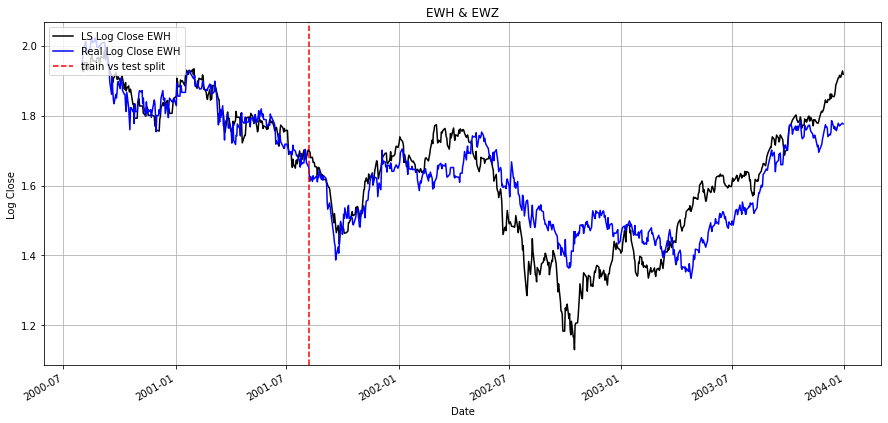

In [35]:
s1s2['Log_Close1_LS'] = s1s2['Mu_LS'] + s1s2['Gamma_LS'] * s1s2['Log_Close2']

s1s2['Log_Close1_LS'].plot(figsize = (15,7), color = 'black', label = 'LS Log Close %s' % (stockcode1))
s1s2['Log_Close1'].plot(color = 'blue', label = 'Real Log Close %s' % (stockcode1))

plt.axvline(x=split_date, label='train vs test split', c='red', linestyle = '--')
plt.grid(True)
plt.legend(loc="upper left")
plt.ylabel(ylabel='Log Close')
plt.title('%s & %s' % (stockcode1, stockcode2));

### LS trading signals and analysis

We first compute the centered spread:

$$ \begin{align}
Centered Spread_{LS} &= s_{1,t}−γ s_{2,t} - μ\\
\end{align}$$

We use a parametric approach, in which if the Z-score of Centered Spread is over +.8 we short, and under -.8 we long. 

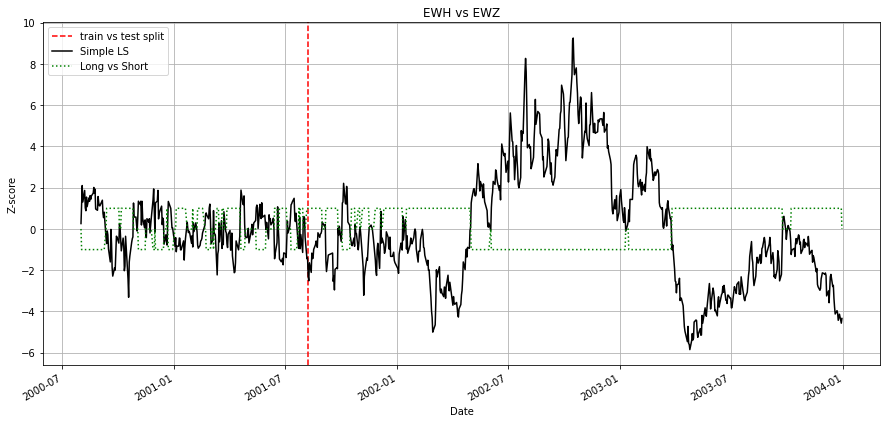

In [36]:
compute_spread(s1s2, 'Log_Close1', 'Log_Close2', 'Mu_LS', 'Gamma_LS', 'Spread_LS')

generate_Z_score_simple(df=s1s2, Spread_Col = 'Spread_LS', Z_Score_Col = 'Z_Score_LS', n=train_len)

s1s2['Threshold_Short'] = short_threshold
s1s2['Threshold_Long'] = long_threshold

generate_signal(df=s1s2, Z_Score_Col='Z_Score_LS', Threshold_Long_Col = 'Threshold_Long', 
                    Threshold_Short_Col = 'Threshold_Short', Signal_Col = 'Signal_LS')

compute_weights(df=s1s2, Gamma_Col = 'Gamma_LS', W1_Col = 'W1_LS', W2_Col = 'W2_LS')

compute_returns(df=s1s2, Signal_Col='Signal_LS', W1_Col = 'W1_LS', W2_Col = 'W2_LS',
               Daily_Returns_Col = 'Daily_Returns_LS', Cum_Returns_Col = 'Cum_Returns_LS')

s1s2['Cum_Returns_Test_LS'] = (1+s1s2[train_len+1:]['Daily_Returns_LS']).cumprod()


calculate_signal_change(df=s1s2, Signal_Col = 'Signal_LS', Signal_Change_Col = 'Signal_Change_LS')

compute_quadratic_variation(df=s1s2, Parameter_Col = 'Mu_LS', Quadratic_Variation_Col = 'Mu_LS_QV')

compute_quadratic_variation(df=s1s2, Parameter_Col = 'Gamma_LS', Quadratic_Variation_Col = 'Gamma_LS_QV')



plt.axvline(x=split_date, label='train vs test split', c='red', linestyle = '--')

plot_signals(df=s1s2, Z_Score_Col = 'Z_Score_LS', Signal_Col = 'Signal_LS', Type = 'Simple LS')

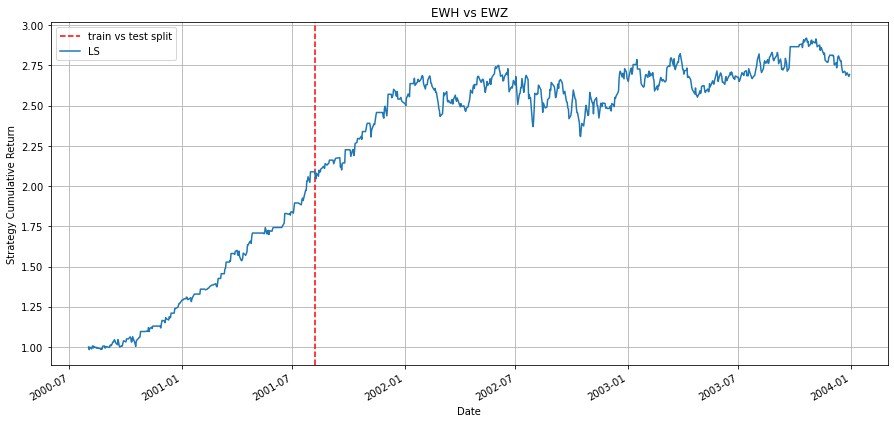

In [37]:
plt.axvline(x=split_date, label='train vs test split', c='red', linestyle = '--')

plot_returns(df=s1s2, Cum_Returns_Col='Cum_Returns_LS', Type = 'LS')

## Time dependent Analysis (Rolling LS)

Instead of assuming static $μ$ and $γ$, here we assume they are time dependent. i.e. $μ_t$ and $γ_t$.

$$ \begin{align}
Centered Spread_{R. LS} &= s_{1,t}−γ_t s_{2,t} - μ_t\\
\end{align}$$

$μ_t$ and $γ_t$ are estimated by LS regression with rolling window of 300 trading days, with estimating frequency of 5 day each. 

The initial $μ_0$ and $γ_0$ are giving by Simple LS estimates above.

3 types of LSs are implemented, namely OLS, WLS with exp weights, and WLS with linear weights. Here we use WLS with linear weights. 

### Generate time dependent $μ_t$ and $γ_t$

In [38]:
def estimate_mu_gamma_rolling_LS(df, s1_Col, s2_Col, Mu_Col, Gamma_Col, window = 300, 
                                 shift = 5, type = 0, Mu_init=0.5, Gamma_init=0.5, train_len=350):

    df_len = len(df)
    df[Mu_Col] = np.nan
    df[Gamma_Col] = np.nan
    t0_update = np.linspace(start = min(train_len, window), 
                            stop = df_len - shift, num = int((df_len - shift - min(train_len, window))/shift)+1)
    
    import statsmodels.formula.api as smf

    from operator import pow

    
    for t0 in t0_update:
        
        if t0-window+1 >= 1:
            window_ = window
        else:
            window_ = train_len
        
        if type == 0:
        # use standard OLS
            model = smf.ols(formula = '%s ~ %s' % (s1_Col, s2_Col), data = df[int(t0-window_+1):int(t0)])
            result = model.fit()
            df[Mu_Col][int(t0)] = result.params[0]
            df[Gamma_Col][int(t0)] = result.params[1]
    
        elif type == 1:
        # WLS with exp weights
            lin_weights=list(range(1,window_))
            exp_weights=list(map(lambda x:pow(x,2),lin_weights))
            model = smf.wls(formula = '%s ~ %s' % (s1_Col, s2_Col), data = df[int(t0-window_+1):int(t0)], weights=exp_weights)
            result = model.fit()
            df[Mu_Col][int(t0)] = result.params[0]
            df[Gamma_Col][int(t0)] = result.params[1]
        
        elif type ==2:
        # WLS with lin weights
            lin_weights=list(range(1,window_))
            model = smf.wls(formula = '%s ~ %s' % (s1_Col, s2_Col), data = df[int(t0-window_+1):int(t0)], weights=lin_weights)
            result = model.fit()
            df[Mu_Col][int(t0)] = result.params[0]
            df[Gamma_Col][int(t0)] = result.params[1]
    
    df[[Mu_Col, Gamma_Col]] = df[[Mu_Col,Gamma_Col]].fillna(method="ffill")
    
    #fill NA
    df[[Mu_Col]] = df[[Mu_Col]].fillna(value = Mu_init)
    df[[Gamma_Col]] = df[[Gamma_Col]].fillna(value = Gamma_init)
    
    #smoothing
    df[Mu_Col] = df[Mu_Col].rolling(30, min_periods=1).mean()
    df[Gamma_Col] = df[Gamma_Col].rolling(30, min_periods=1).mean()

In [39]:
estimate_mu_gamma_rolling_LS(df = s1s2, s1_Col = 'Log_Close1', s2_Col = 'Log_Close2', 
                             Mu_Col = 'Mu_Rolling_LS', Gamma_Col = 'Gamma_Rolling_LS', type = 2, 
                             Mu_init = s1s2['Mu_LS'][0], Gamma_init = s1s2['Gamma_LS'][0], 
                             train_len = train_len)

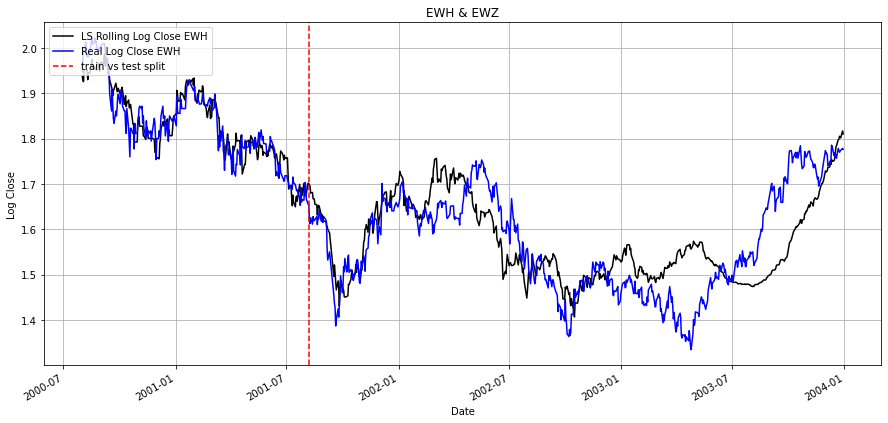

In [40]:
s1s2['Log_Close1_LS_Rolling'] = s1s2['Mu_Rolling_LS'] + s1s2['Gamma_Rolling_LS'] * s1s2['Log_Close2']

s1s2['Log_Close1_LS_Rolling'].plot(figsize = (15,7), color = 'black', label = 'LS Rolling Log Close %s' % (stockcode1))
s1s2['Log_Close1'].plot(color = 'blue', label = 'Real Log Close %s' % (stockcode1))

plt.axvline(x=split_date, label='train vs test split', c='red', linestyle = '--')
plt.grid(True)
plt.legend(loc="upper left")
plt.ylabel(ylabel='Log Close')
plt.title('%s & %s' % (stockcode1, stockcode2));

### Rolling LS trading signals and analysis

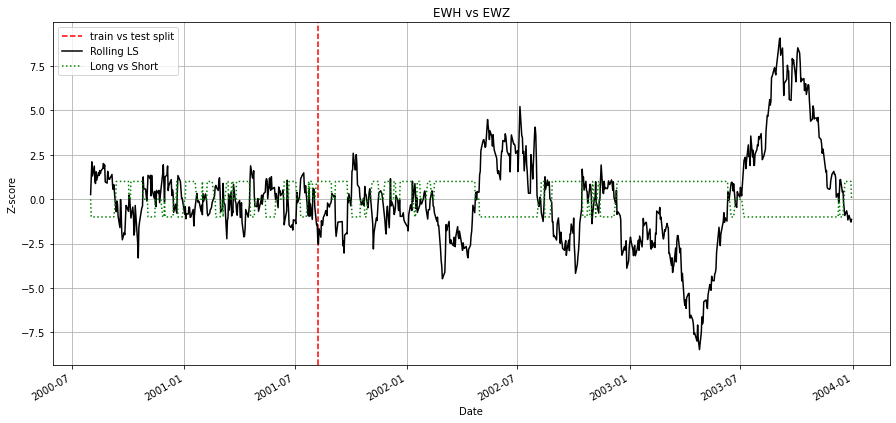

In [41]:
compute_spread(s1s2, 'Log_Close1', 'Log_Close2', 
               'Mu_Rolling_LS', 'Gamma_Rolling_LS', 'Spread_Rolling_LS')

generate_Z_score_simple(df=s1s2, Spread_Col = 'Spread_Rolling_LS', Z_Score_Col = 'Z_Score_Rolling_LS', n=train_len)

s1s2['Threshold_Short'] = short_threshold
s1s2['Threshold_Long'] = long_threshold

generate_signal(df=s1s2, Z_Score_Col='Z_Score_Rolling_LS', Threshold_Long_Col = 'Threshold_Long', 
                    Threshold_Short_Col = 'Threshold_Short', Signal_Col = 'Signal_Rolling_LS')

compute_weights(df=s1s2, Gamma_Col = 'Gamma_Rolling_LS', W1_Col = 'W1_Rolling_LS', W2_Col = 'W2_Rolling_LS')

compute_returns(df=s1s2, Signal_Col='Signal_Rolling_LS', W1_Col = 'W1_Rolling_LS', W2_Col = 'W2_Rolling_LS',
               Daily_Returns_Col = 'Daily_Returns_Rolling_LS', Cum_Returns_Col = 'Cum_Returns_Rolling_LS')

s1s2['Cum_Returns_Test_Rolling_LS'] = (1+s1s2[train_len+1:]['Daily_Returns_Rolling_LS']).cumprod()


calculate_signal_change(df=s1s2, Signal_Col = 'Signal_Rolling_LS', Signal_Change_Col = 'Signal_Change_Rolling_LS')

compute_quadratic_variation(df=s1s2, Parameter_Col = 'Mu_Rolling_LS', Quadratic_Variation_Col = 'Mu_Rolling_LS_QV')

compute_quadratic_variation(df=s1s2, Parameter_Col = 'Gamma_Rolling_LS', Quadratic_Variation_Col = 'Gamma_Rolling_LS_QV')


plt.axvline(x=split_date, label='train vs test split', c='red', linestyle = '--')

plot_signals(df=s1s2, Z_Score_Col = 'Z_Score_Rolling_LS', Signal_Col = 'Signal_Rolling_LS', Type = 'Rolling LS')

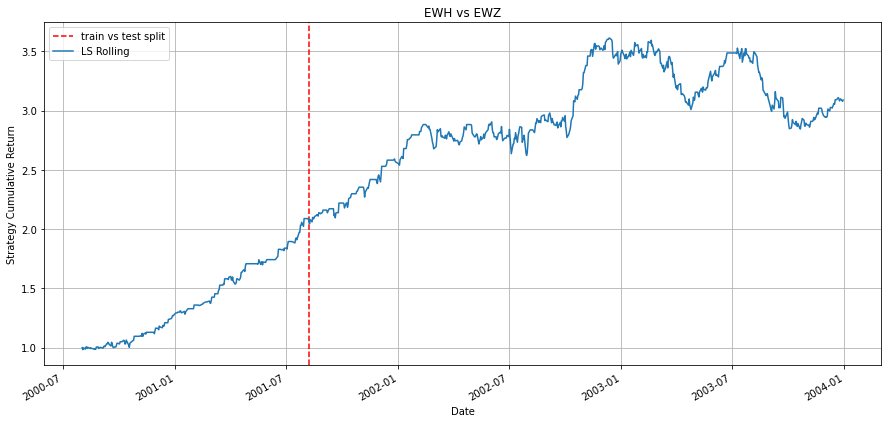

In [42]:
plt.axvline(x=split_date, label='train vs test split', c='red', linestyle = '--')

plot_returns(df=s1s2, Cum_Returns_Col='Cum_Returns_Rolling_LS', Type = 'LS Rolling')

## Time dependent Analysis (Kalman Filter)

Basic Kalman Filtering model:

$$ \begin{align}
α_{t+1} & =T_tα_t+R_tη_t\\
y_{1t} & =Z_tα_t+ϵ_t
\end{align}$$


The initial $μ_0$ and $γ_0$ are giving by Simple LS estimates above.

I use pykalman package: https://pykalman.github.io/

### Generate time dependent $μ_t$ and $γ_t$

In [43]:
def estimate_mu_gamma_Kalman(df, s1_Col, s2_Col, Mu_Col, Gamma_Col, Mu_init=0.5, Gamma_init=0.5):
    
    from pykalman import KalmanFilter

    df[Mu_Col] = np.nan
    df[Gamma_Col] = np.nan

    Tt = np.array([[1, 0], [0, 1]])
    Qt = np.array([[1e-5, 0], [0, 1e-5]])
    Zt = np.vstack([np.ones(df[s2_Col].shape), df[s2_Col]]).T[:, np.newaxis]
    Ht = np.array([1e-3])
    a1 = np.array([Mu_init, Gamma_init])
    P1 = 1e-5 * np.array([[1, 0], [0, 1]]) 

    kf = KalmanFilter(transition_matrices = Tt, 
                      observation_matrices = Zt, 
                      transition_covariance = Qt, 
                     initial_state_mean = a1, 
                     initial_state_covariance = P1,
                     observation_covariance = Ht)

    measurements = df[s1_Col].to_numpy()

    #kf = kf.em(measurements) #not used here

    filtered_state_means, filtered_state_covariances = kf.filter(measurements)
    
    df[Mu_Col] = filtered_state_means[:, 0]
    df[Gamma_Col] = filtered_state_means[:, 1]
    
    #smoothing
    df[Mu_Col] = df[Mu_Col].rolling(30, min_periods=1).mean()
    df[Gamma_Col] = df[Gamma_Col].rolling(30, min_periods=1).mean()

In [44]:
estimate_mu_gamma_Kalman(df = s1s2, s1_Col = 'Log_Close1', s2_Col = 'Log_Close2', 
                         Mu_Col = 'Mu_Kalman_Filtering', Gamma_Col = 'Gamma_Kalman_Filtering', 
                         Mu_init = s1s2['Mu_LS'][0], Gamma_init = s1s2['Gamma_LS'][0])

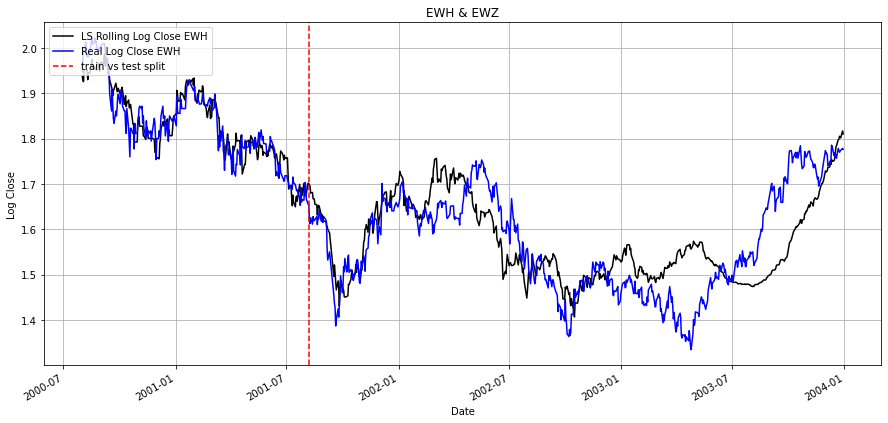

In [45]:
s1s2['Log_Close1_LS_Rolling'] = s1s2['Mu_Rolling_LS'] + s1s2['Gamma_Rolling_LS'] * s1s2['Log_Close2']

s1s2['Log_Close1_LS_Rolling'].plot(figsize = (15,7), color = 'black', label = 'LS Rolling Log Close %s' % (stockcode1))
s1s2['Log_Close1'].plot(color = 'blue', label = 'Real Log Close %s' % (stockcode1))

plt.axvline(x=split_date, label='train vs test split', c='red', linestyle = '--')
plt.grid(True)
plt.legend(loc="upper left")
plt.ylabel(ylabel='Log Close')
plt.title('%s & %s' % (stockcode1, stockcode2));

### Kalman Filtering trading signals and anslysis

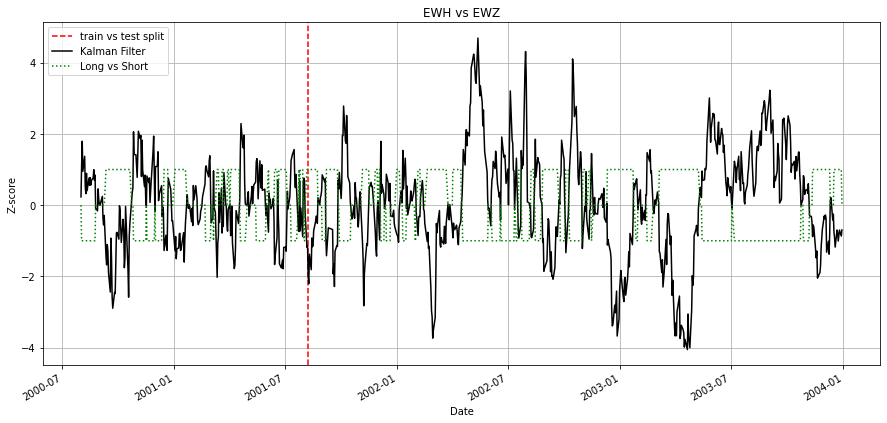

In [46]:
compute_spread(s1s2, 'Log_Close1', 'Log_Close2', 
               'Mu_Kalman_Filtering', 'Gamma_Kalman_Filtering', 'Spread_Kalman_Filtering')

generate_Z_score_simple(df=s1s2, Spread_Col = 'Spread_Kalman_Filtering', 
                        Z_Score_Col = 'Z_Score_Kalman_Filtering', n=train_len)

s1s2['Threshold_Short'] = short_threshold
s1s2['Threshold_Long'] = long_threshold

generate_signal(df=s1s2, Z_Score_Col='Z_Score_Kalman_Filtering', Threshold_Long_Col = 'Threshold_Long', 
                    Threshold_Short_Col = 'Threshold_Short', Signal_Col = 'Signal_Kalman_Filtering')

compute_weights(df=s1s2, Gamma_Col = 'Gamma_Kalman_Filtering', W1_Col = 'W1_Kalman_Filtering', W2_Col = 'W2_Kalman_Filtering')

compute_returns(df=s1s2, Signal_Col='Signal_Kalman_Filtering', W1_Col = 'W1_Kalman_Filtering', W2_Col = 'W2_Kalman_Filtering',
               Daily_Returns_Col = 'Daily_Returns_Kalman_Filtering', Cum_Returns_Col = 'Cum_Returns_Kalman_Filtering')

s1s2['Cum_Returns_Test_Kalman_Filtering'] = (1+s1s2[train_len+1:]['Daily_Returns_Kalman_Filtering']).cumprod()


calculate_signal_change(df=s1s2, Signal_Col = 'Signal_Kalman_Filtering', Signal_Change_Col = 'Signal_Change_Kalman_Filtering')

compute_quadratic_variation(df=s1s2, Parameter_Col = 'Mu_Kalman_Filtering', Quadratic_Variation_Col = 'Mu_Kalman_Filtering_QV')

compute_quadratic_variation(df=s1s2, Parameter_Col = 'Gamma_Kalman_Filtering', Quadratic_Variation_Col = 'Gamma_Kalman_Filtering_QV')


plt.axvline(x=split_date, label='train vs test split', c='red', linestyle = '--')

plot_signals(df=s1s2, Z_Score_Col = 'Z_Score_Kalman_Filtering', Signal_Col = 'Signal_Kalman_Filtering', Type = 'Kalman Filter')

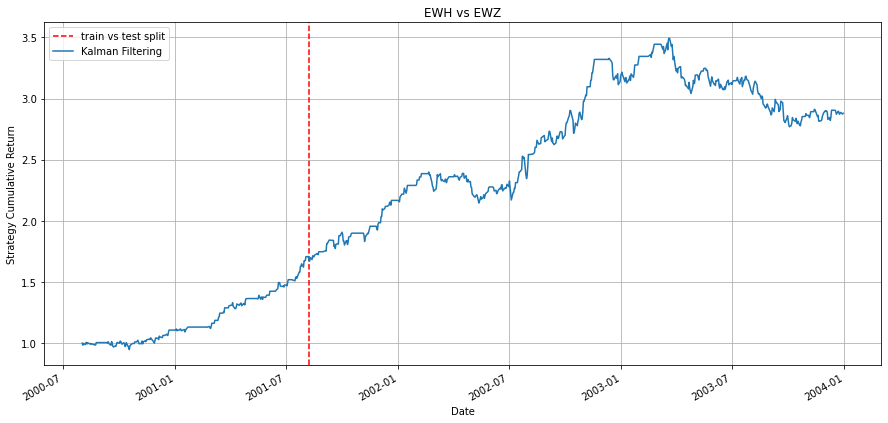

In [47]:
plt.axvline(x=split_date, label='train vs test split', c='red', linestyle = '--')

plot_returns(df=s1s2, Cum_Returns_Col='Cum_Returns_Kalman_Filtering', Type = 'Kalman Filtering')

## Time dependent Analysis (Kalman Filter with EMA Z-Score)

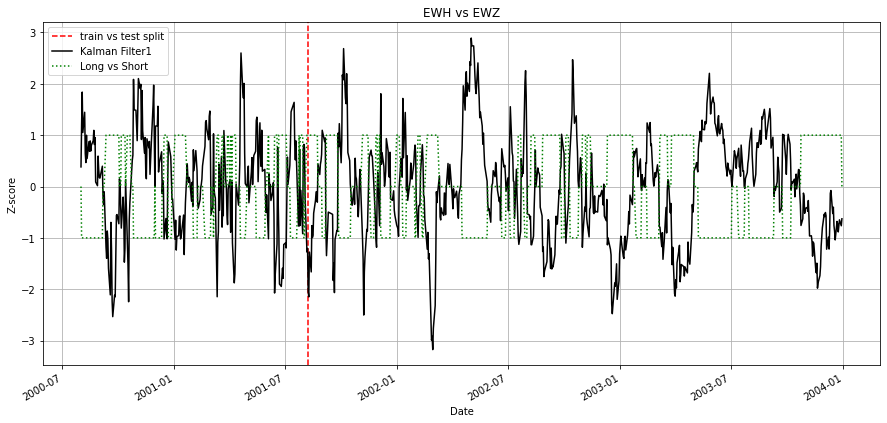

In [48]:
compute_spread(s1s2, 'Log_Close1', 'Log_Close2', 
               'Mu_Kalman_Filtering', 'Gamma_Kalman_Filtering', 'Spread_Kalman_Filtering') #actually no need here

generate_Z_score_EMA(df=s1s2, Spread_Col = 'Spread_Kalman_Filtering', 
                     Mean_Col = 'Mean_Kalman_Filtering', Demeaned_Col = 'Demeaned_Kalman_Filtering', 
                     Demeaned_Squared_Col = 'Demeaned_Squared_Kalman_Filtering', Var_Col = 'Var_Kalman_Filtering', 
                     Z_Score_Col = 'Z_Score_Kalman_Filtering1')

s1s2['Threshold_Short'] = short_threshold
s1s2['Threshold_Long'] = long_threshold

generate_signal(df=s1s2, Z_Score_Col='Z_Score_Kalman_Filtering1', Threshold_Long_Col = 'Threshold_Long', 
                    Threshold_Short_Col = 'Threshold_Short', Signal_Col = 'Signal_Kalman_Filtering1')

compute_weights(df=s1s2, Gamma_Col = 'Gamma_Kalman_Filtering', W1_Col = 'W1_Kalman_Filtering', W2_Col = 'W2_Kalman_Filtering')

compute_returns(df=s1s2, Signal_Col='Signal_Kalman_Filtering1', W1_Col = 'W1_Kalman_Filtering', W2_Col = 'W2_Kalman_Filtering',
               Daily_Returns_Col = 'Daily_Returns_Kalman_Filtering1', Cum_Returns_Col = 'Cum_Returns_Kalman_Filtering1')

s1s2['Cum_Returns_Test_Kalman_Filtering1'] = (1+s1s2[train_len+1:]['Daily_Returns_Kalman_Filtering1']).cumprod()

calculate_signal_change(df=s1s2, Signal_Col = 'Signal_Kalman_Filtering1', Signal_Change_Col = 'Signal_Change_Kalman_Filtering1')

plt.axvline(x=split_date, label='train vs test split', c='red', linestyle = '--')

plot_signals(df=s1s2, Z_Score_Col = 'Z_Score_Kalman_Filtering1', Signal_Col = 'Signal_Kalman_Filtering1', Type = 'Kalman Filter1')

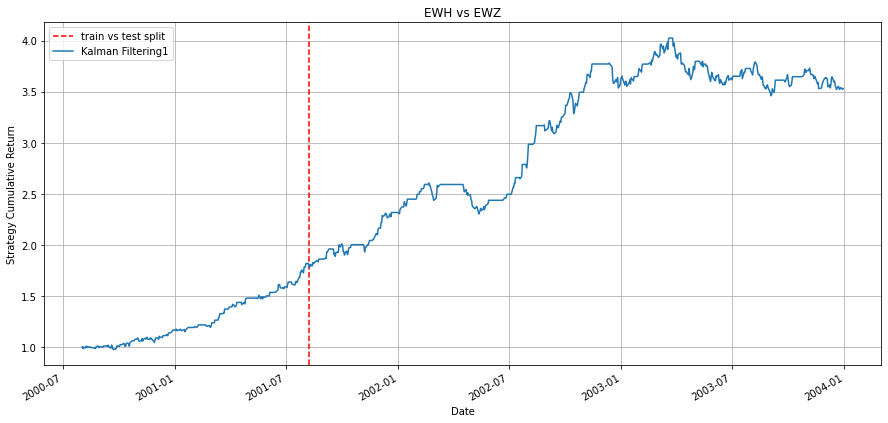

In [49]:
plt.axvline(x=split_date, label='train vs test split', c='red', linestyle = '--')

plot_returns(df=s1s2, Cum_Returns_Col='Cum_Returns_Kalman_Filtering1', Type = 'Kalman Filtering1')

## Final Comparison

### Centered Spread Comparison

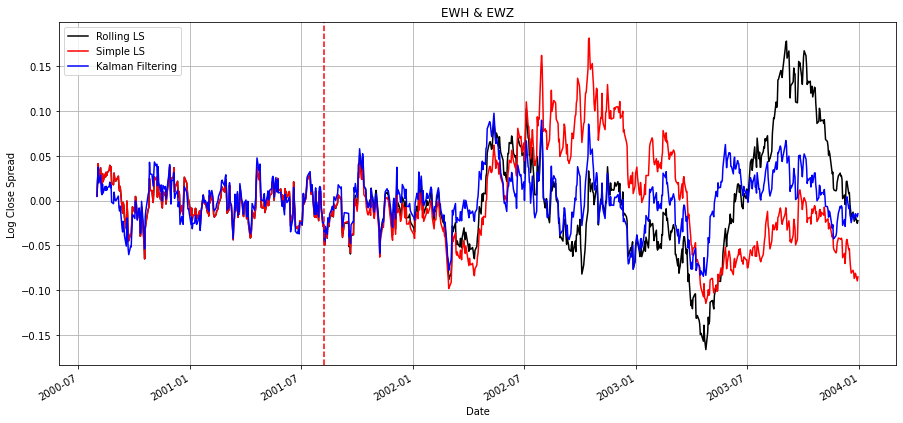

In [50]:
s1s2['Spread_Rolling_LS'].plot(figsize = (15,7), color = 'black', label = 'Rolling LS')
s1s2['Spread_LS'].plot(color = 'red', label = 'Simple LS')
s1s2['Spread_Kalman_Filtering'].plot(color = 'blue', label = 'Kalman Filtering')

plt.grid(True)
plt.legend(loc="upper left")
plt.axvline(x=split_date, label='train vs test split', c='red', linestyle = '--')
plt.ylabel(ylabel='Log Close Spread')
plt.title('%s & %s' % (stockcode1, stockcode2));

### Stationary tests for spreads

In [51]:
from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test
result_train_LS, p_train_LS, *_, critical_train_LS, _ = adfuller(s1s2[:train_len]['Spread_LS'])
result_train_Rolling_LS, p_train_Rolling_LS, *_, critical_train_Rolling_LS, _ = adfuller(s1s2[:train_len]['Spread_Rolling_LS'])
result_train_Kalman_Filtering, p_train_Kalman_Filtering, *_, critical_train_Kalman_Filtering, _ = adfuller(s1s2[:train_len]['Spread_Kalman_Filtering'])


print('Augmented Dickey Fuller test for LS (training dataset):')

print('Cointegration test t-stat = %f' % (result_train_LS))

print('P-value = %f' % (p_train_LS))

print('Critical Values for 1%% 5%% 10%% are %s & %s & %s.' % 
      (critical_train_LS['1%'], critical_train_LS['5%'], critical_train_LS['10%']))


print('--------------------------')

print('Augmented Dickey Fuller test for Rolling LS (training dataset):')

print('Cointegration test t-stat = %f' % (result_train_Rolling_LS))

print('P-value = %f' % (p_train_Rolling_LS))

print('Critical Values for 1%% 5%% 10%% are %s & %s & %s.' % 
      (critical_train_Rolling_LS['1%'], critical_train_Rolling_LS['5%'], critical_train_Rolling_LS['10%']))

print('--------------------------')

print('Augmented Dickey Fuller test for Kalaman Filtering (training dataset):')

print('Cointegration test t-stat = %f' % (result_train_Kalman_Filtering))

print('P-value = %f' % (p_train_Kalman_Filtering))

print('Critical Values for 1%% 5%% 10%% are %s & %s & %s.' % 
      (critical_train_Kalman_Filtering['1%'], critical_train_Kalman_Filtering['5%'], critical_train_Kalman_Filtering['10%']))

Augmented Dickey Fuller test for LS (training dataset):
Cointegration test t-stat = -4.241058
P-value = 0.000561
Critical Values for 1% 5% 10% are -3.4565688966099373 & -2.8730786194395455 & -2.5729189953388762.
--------------------------
Augmented Dickey Fuller test for Rolling LS (training dataset):
Cointegration test t-stat = -4.241058
P-value = 0.000561
Critical Values for 1% 5% 10% are -3.4565688966099373 & -2.8730786194395455 & -2.5729189953388762.
--------------------------
Augmented Dickey Fuller test for Kalaman Filtering (training dataset):
Cointegration test t-stat = -4.114216
P-value = 0.000917
Critical Values for 1% 5% 10% are -3.4565688966099373 & -2.8730786194395455 & -2.5729189953388762.


In [52]:
from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test
result_LS, p_LS, *_, critical_LS, _ = adfuller(s1s2['Spread_LS'])
result_Rolling_LS, p_Rolling_LS, *_, critical_Rolling_LS, _ = adfuller(s1s2['Spread_Rolling_LS'])
result_Kalman_Filtering, p_Kalman_Filtering, *_, critical_Kalman_Filtering, _ = adfuller(s1s2['Spread_Kalman_Filtering'])


print('Augmented Dickey Fuller test for LS (full dataset):')

print('Cointegration test t-stat = %f' % (result_LS))

print('P-value = %f' % (p_LS))

print('Critical Values for 1%% 5%% 10%% are %s & %s & %s.' % 
      (critical_LS['1%'], critical_LS['5%'], critical_LS['10%']))


print('--------------------------')

print('Augmented Dickey Fuller test for Rolling LS (full dataset):')

print('Cointegration test t-stat = %f' % (result_Rolling_LS))

print('P-value = %f' % (p_Rolling_LS))

print('Critical Values for 1%% 5%% 10%% are %s & %s & %s.' % 
      (critical_Rolling_LS['1%'], critical_Rolling_LS['5%'], critical_Rolling_LS['10%']))

print('--------------------------')

print('Augmented Dickey Fuller test for Kalaman Filtering (full dataset):')

print('Cointegration test t-stat = %f' % (result_Kalman_Filtering))

print('P-value = %f' % (p_Kalman_Filtering))

print('Critical Values for 1%% 5%% 10%% are %s & %s & %s.' % 
      (critical_Kalman_Filtering['1%'], critical_Kalman_Filtering['5%'], critical_Kalman_Filtering['10%']))

Augmented Dickey Fuller test for LS (full dataset):
Cointegration test t-stat = -1.897784
P-value = 0.333104
Critical Values for 1% 5% 10% are -3.4381124572018487 & -2.864966469499829 & -2.5685945257518994.
--------------------------
Augmented Dickey Fuller test for Rolling LS (full dataset):
Cointegration test t-stat = -2.901818
P-value = 0.045137
Critical Values for 1% 5% 10% are -3.438039434877692 & -2.8649342774762423 & -2.5685773775887872.
--------------------------
Augmented Dickey Fuller test for Kalaman Filtering (full dataset):
Cointegration test t-stat = -6.542177
P-value = 0.000000
Critical Values for 1% 5% 10% are -3.4380124044615803 & -2.8649223608717205 & -2.5685710298388504.


### $μ_t$ and $γ_t$ Comparison

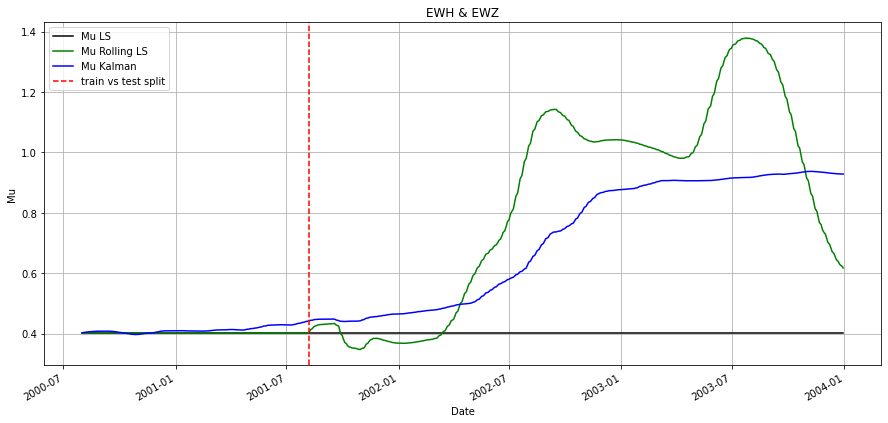

In [53]:
s1s2['Mu_LS'].plot(figsize = (15,7), color = 'black', label = 'Mu LS')
s1s2['Mu_Rolling_LS'].plot(color = 'green', label = 'Mu Rolling LS')
s1s2['Mu_Kalman_Filtering'].plot(color = 'blue', label = 'Mu Kalman')

plt.axvline(x=split_date, label='train vs test split', c='red', linestyle = '--')
plt.grid(True)
plt.legend(loc="upper left")
plt.ylabel(ylabel='Mu')
plt.title('%s & %s' % (stockcode1, stockcode2));

In [54]:

print('LS Training Mu Total QV = %f' % s1s2[:train_len]['Mu_LS_QV'].sum())
print('Rolling LS Training Mu Total QV = %f' % s1s2[:train_len]['Mu_Rolling_LS_QV'].sum())
print('Kalman Filtering Total Mu Total QV = %f' % s1s2[:train_len]['Mu_Kalman_Filtering_QV'].sum())

print('------------------------')


print('LS Training Mu mean QV = %f' % s1s2[:train_len]['Mu_LS_QV'].mean())
print('Rolling LS Training Mu mean QV = %f' % s1s2[:train_len]['Mu_Rolling_LS_QV'].mean())
print('Kalman Filtering Total Mu mean QV = %f' % s1s2[:train_len]['Mu_Kalman_Filtering_QV'].mean())

print('------------------------')

print('LS full dataset Mu Total QV = %f' % s1s2['Mu_LS_QV'].sum())
print('Rolling LS full dataset Mu Total QV = %f' % s1s2['Mu_Rolling_LS_QV'].sum())
print('Kalman Filtering full dataset Mu Total QV = %f' % s1s2['Mu_Kalman_Filtering_QV'].sum())

print('------------------------')

print('LS full dataset Mu Total QV = %f' % s1s2['Mu_LS_QV'].mean())
print('Rolling LS full dataset Mu Total QV = %f' % s1s2['Mu_Rolling_LS_QV'].mean())
print('Kalman Filtering full dataset Mu Total QV = %f' % s1s2['Mu_Kalman_Filtering_QV'].mean())


LS Training Mu Total QV = 0.000000
Rolling LS Training Mu Total QV = 0.000000
Kalman Filtering Total Mu Total QV = 3.263980
------------------------
LS Training Mu mean QV = 0.000000
Rolling LS Training Mu mean QV = 0.000000
Kalman Filtering Total Mu mean QV = 0.012700
------------------------
LS full dataset Mu Total QV = 0.000000
Rolling LS full dataset Mu Total QV = 1616.902623
Kalman Filtering full dataset Mu Total QV = 120.311635
------------------------
LS full dataset Mu Total QV = 0.000000
Rolling LS full dataset Mu Total QV = 1.886701
Kalman Filtering full dataset Mu Total QV = 0.140387


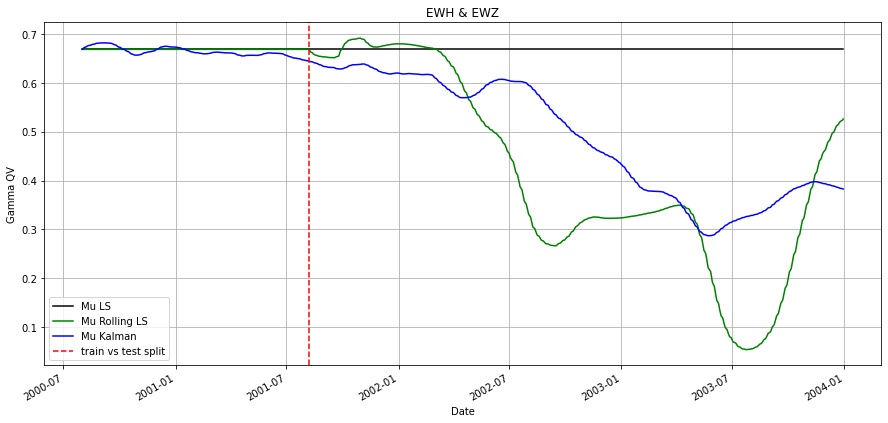

In [55]:
s1s2['Gamma_LS'].plot(figsize = (15,7), color = 'black', label = 'Mu LS')
s1s2['Gamma_Rolling_LS'].plot(color = 'green', label = 'Mu Rolling LS')
s1s2['Gamma_Kalman_Filtering'].plot(color = 'blue', label = 'Mu Kalman')

plt.axvline(x=split_date, label='train vs test split', c='red', linestyle = '--')
plt.grid(True)
plt.legend(loc="lower left")
plt.ylabel(ylabel='Gamma QV')
plt.title('%s & %s' % (stockcode1, stockcode2));

In [56]:
print('LS Training Gamma Total QV = %f' % s1s2[:train_len]['Gamma_LS_QV'].sum())
print('Rolling LS Training Gamma Total QV = %f' % s1s2[:train_len]['Gamma_Rolling_LS_QV'].sum())
print('Kalman Filtering Total Gamma Total QV = %f' % s1s2[:train_len]['Gamma_Kalman_Filtering_QV'].sum())

print('------------------------')


print('LS Training Gamma mean QV = %f' % s1s2[:train_len]['Gamma_LS_QV'].mean())
print('Rolling LS Training Gamma mean QV = %f' % s1s2[:train_len]['Gamma_Rolling_LS_QV'].mean())
print('Kalman Filtering Total Gamma mean QV = %f' % s1s2[:train_len]['Gamma_Kalman_Filtering_QV'].mean())

print('------------------------')

print('LS full dataset Gamma Total QV = %f' % s1s2['Gamma_LS_QV'].sum())
print('Rolling LS full dataset Gamma Total QV = %f' % s1s2['Gamma_Rolling_LS_QV'].sum())
print('Kalman Filtering full dataset Gamma Total QV = %f' % s1s2['Gamma_Kalman_Filtering_QV'].sum())

print('------------------------')

print('LS full dataset Gamma Total QV = %f' % s1s2['Gamma_LS_QV'].mean())
print('Rolling LS full dataset Gamma Total QV = %f' % s1s2['Gamma_Rolling_LS_QV'].mean())
print('Kalman Filtering full dataset Gamma Total QV = %f' % s1s2['Gamma_Kalman_Filtering_QV'].mean())

LS Training Gamma Total QV = 0.000000
Rolling LS Training Gamma Total QV = 0.000000
Kalman Filtering Total Gamma Total QV = 6.895762
------------------------
LS Training Gamma mean QV = 0.000000
Rolling LS Training Gamma mean QV = 0.000000
Kalman Filtering Total Gamma mean QV = 0.026832
------------------------
LS full dataset Gamma Total QV = 0.000000
Rolling LS full dataset Gamma Total QV = 596.387716
Kalman Filtering full dataset Gamma Total QV = 93.377761
------------------------
LS full dataset Gamma Total QV = 0.000000
Rolling LS full dataset Gamma Total QV = 0.695902
Kalman Filtering full dataset Gamma Total QV = 0.108959


### PL Comparison (testing period)

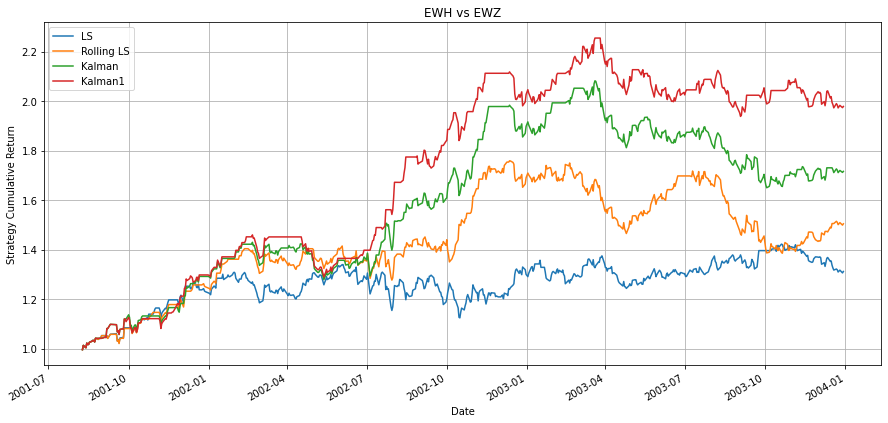

In [57]:
plot_returns(df=s1s2, Cum_Returns_Col='Cum_Returns_Test_LS', Type = 'LS')
plot_returns(df=s1s2, Cum_Returns_Col='Cum_Returns_Test_Rolling_LS', Type = 'Rolling LS')
plot_returns(df=s1s2, Cum_Returns_Col='Cum_Returns_Test_Kalman_Filtering', Type = 'Kalman')
plot_returns(df=s1s2, Cum_Returns_Col='Cum_Returns_Test_Kalman_Filtering1', Type = 'Kalman1')

## Export to file

In [58]:
if data_export ==1:
    if data_source ==0:
        s1s2.to_csv('s1s2 yahoo div unadjusted.csv', index=True)
    if data_source ==1:
        s1s2.to_csv('s1s2 yahoo div adjusted.csv', index=True)
    if data_source ==2:
        s1s2.to_csv('s1s2 quandl.csv', index=True)